In [27]:
import torch
from torchvision import datasets, transforms
import torch.autograd 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from numba import vectorize,cuda
import random 
import time

train_loader= torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=64, shuffle=True) 
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=64, shuffle=True) 



MaxEpoch=10

accuracy_train_1 =np.zeros(MaxEpoch)
accuracy_test_1 = np.zeros(MaxEpoch)

accuracy_train_2 =np.zeros(MaxEpoch)
accuracy_test_2 = np.zeros(MaxEpoch)


In [29]:
class Model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.m=nn.Linear(784,10)
        
    def forward(self,x):
        return(F.tanh(self.m((x))))

The Gradient descent took 1.987 min


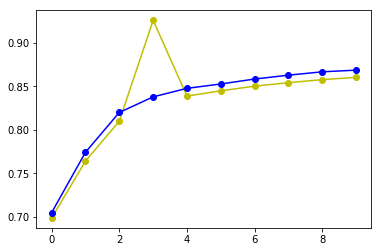

La valeur d'accuracy en test à la dernière itération est de 0.86868688


In [33]:
module=Model()
module.m.weight.data.uniform_(-0.001, 0.001) 
l = nn.MSELoss()
optimizer= torch.optim.SGD(module.parameters(),lr=0.0002)
start=time.time()

for iteration in range(MaxEpoch) :   
    for x,y in train_loader:
        optimizer.zero_grad()
        inp=x.view(x.size()[0],784)
        inp=Variable(inp)

        target = y
        y_test = torch.LongTensor(target.unsqueeze(1))
        y2 = torch.FloatTensor(y.size()[0], 10).fill_(-1)
        y2 = y2.scatter_(1,y_test,1)
        y2= Variable(y2)
        
        out= module.forward(inp)
        err =l.forward(out,y2)
        err.backward()
        optimizer.step()
    
    #loss_train[iteration] = loss.data[0]
    for x1,y1 in train_loader:
        x1= Variable(x1.view(x1.size()[0],28*28))
        y1= Variable(y1)
        a= sum(torch.max(module.forward(x1).t(),0)[1]==y1)
        accuracy_train_1[iteration] += a.data[0]
    accuracy_train_1[iteration] /= train_loader.dataset.train_data.size()[0]

    for x1,y1 in test_loader:
        x1= Variable(x1.view(x1.size()[0],28*28))
        y1= Variable(y1)
        a= sum(torch.max(module.forward(x1).t(),0)[1]==y1)
        accuracy_test_1[iteration] += a.data[0]
    accuracy_test_1[iteration] /= test_loader.dataset.test_data.size()[0]


print('The Gradient descent took '+ str(round((time.time()-start)/60,3))+' min')
import matplotlib.pyplot as plt

plt.plot(accuracy_train_1,'y',marker='o')
plt.plot(accuracy_test_1,'b',marker='o')
plt.show()

print("La valeur d'accuracy en test à la dernière itération est de " + str(accuracy_test_1[MaxEpoch-1]))


# Essayons avec un optimizer plus puissant, ADAMAX

The Gradient descent took 2.02 min


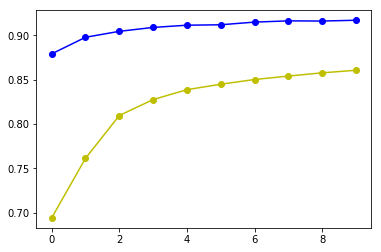

La valeur d'accuracy en test à la dernière itération est de 0.91688686


In [34]:
module=Model()
module.m.weight.data.uniform_(-0.001, 0.001) 
l = nn.MSELoss()

optimizer= torch.optim.Adamax(module.parameters(),lr=0.0002)
start=time.time()
for iteration in range(MaxEpoch) :   
    for x,y in train_loader:
        inp=x.view(x.size()[0],784)
        inp=Variable(inp)

        target = y
        y_test = torch.LongTensor(target.unsqueeze(1))
        y2 = torch.FloatTensor(y.size()[0], 10).fill_(-1)
        y2 = y2.scatter_(1,y_test,1)
        y2= Variable(y2)
        optimizer.zero_grad()
        out= module.forward(inp)
        err =l.forward(out,y2)
        err.backward()
        optimizer.step()
    
    #loss_train[iteration] = loss.data[0]
    for x1,y1 in train_loader:
        x1= Variable(x1.view(x1.size()[0],28*28))
        y1= Variable(y1)
        a= sum(torch.max(module.forward(x1).t(),0)[1]==y1)
        accuracy_train_2[iteration] += a.data[0]
    accuracy_train_2[iteration] /= train_loader.dataset.train_data.size()[0]

    for x1,y1 in test_loader:
        x1= Variable(x1.view(x1.size()[0],28*28))
        y1= Variable(y1)
        a= sum(torch.max(module.forward(x1).t(),0)[1]==y1)
        accuracy_test_2[iteration] += a.data[0]
    accuracy_test_2[iteration] /= test_loader.dataset.test_data.size()[0]

print('The Gradient descent took '+ str(round((time.time()-start)/60,3))+' min')
import matplotlib.pyplot as plt

plt.plot(accuracy_train,'y',marker='o')
plt.plot(accuracy_test,'b',marker='o')
plt.show()

print("La valeur d'accuracy en test à la dernière itération est de " + str(accuracy_test[MaxEpoch-1]))


# Extrement rapide et précis par rapport à la version sans torch et sans l'optimizer